# Cluster Visualization Notebook

本 notebook 用于对 `combined_features_cluster.csv` 进行基础可视化分析：
- 加载全局聚类结果（所有 tiles 合并后的细胞级特征）
- 在 PCA 空间中可视化聚类
- 查看每个聚类的细胞数分布
- 绘制各簇平均 marker 表达的热图
- 绘制单个 marker 在不同聚类中的分布（箱线图/小提琴图）
- （可选）按样本维度查看 cluster 组成差异


In [14]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

sns.set(style="whitegrid")

csv_path = "/nfs5/zyh/MUF-Clust/cluster_outputs/combined_features_cluster.csv"
assert os.path.isfile(csv_path), f'CSV not found: {csv_path}'

df = pd.read_csv(csv_path)
df.head()

,cell_id,tile_x,tile_y,label,local_x,local_y,Opal570,Opal690,Opal480,Opal620,...,Opal520,__source_csv,cluster,confidence,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
0,15360_29184_1,15360,29184,1,31.317406,7.068259,1.126280,1.757679,1.156997,11.037542,...,0.464164,/nfs5/zyh/MUF-Clust/outputs/102_Scan1/tile_153...,0,0.215948,-0.705443,0.385865,-0.029736,-0.417374,-0.268863,-0.336632
1,15360_29184_10,15360,29184,10,265.644444,15.074074,5.288889,4.222222,6.785185,23.466667,...,2.503704,/nfs5/zyh/MUF-Clust/outputs/102_Scan1/tile_153...,11,0.208341,0.091726,0.863512,0.140437,-0.751853,-0.563356,-0.577974
2,15360_29184_100,15360,29184,100,156.402256,120.048872,5.518797,3.296992,10.560150,25.695488,...,2.913534,/nfs5/zyh/MUF-Clust/outputs/102_Scan1/tile_153...,11,0.430862,0.264369,1.084387,0.154844,-0.762904,-0.642293,-0.505288
3,15360_29184_101,15360,29184,101,303.459184,120.433673,1.918367,1.137755,4.168367,24.836735,...,1.693877,/nfs5/zyh/MUF-Clust/outputs/102_Scan1/tile_153...,3,0.469539,0.210270,-0.703923,3.701233,0.118778,-0.604685,-0.501827
4,15360_29184_102,15360,29184,102,318.753623,117.833333,1.826087,2.021739,3.260870,15.202900,...,0.913043,/nfs5/zyh/MUF-Clust/outputs/102_Scan1/tile_153...,8,0.550772,-0.350423,-0.032759,1.351141,-0.176323,-0.334959,-0.327174


In [15]:
print('Total cells:', len(df))
print('Clusters:', sorted(df['cluster'].unique()))
print(df[['cluster']].value_counts().sort_index().rename('count'))


Total cells: 35237
Clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
cluster
0          16200
1           1293
2            657
3            820
4            318
5            251
6           2079
7           6667
8           3687
9            962
10          1153
11          1150
Name: count, dtype: int64


## 1. PCA 空间中的聚类分布

在 PCA 降维后的空间中查看细胞分布，颜色表示聚类标签。


## 1.x t-SNE 空间中的聚类分布

使用 t-SNE 对 PCA 特征进一步降维到 2D 空间，并按聚类标签着色。注意：t-SNE 计算量较大，这里会对细胞进行抽样。

Running t-SNE on 10000 cells...


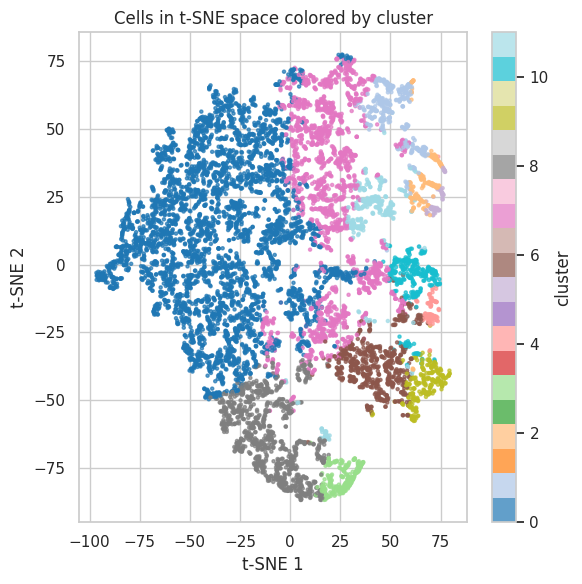

In [16]:
# 使用 PCA 特征作为 t-SNE 输入
X_pca = df[["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6"]].values
labels = df["cluster"].astype(int).values

# 如细胞数过多，先抽样以避免 t-SNE 过慢
max_cells_tsne = 10000
if len(df) > max_cells_tsne:
    sampled_idx = np.random.RandomState(42).choice(len(df), size=max_cells_tsne, replace=False)
    X_input = X_pca[sampled_idx]
    labels_input = labels[sampled_idx]
else:
    X_input = X_pca
    labels_input = labels

print(f"Running t-SNE on {len(X_input)} cells...")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    metric="euclidean",
    random_state=42,
)
X_tsne = tsne.fit_transform(X_input)

plt.figure(figsize=(6, 6))
sc = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=labels_input,
    s=5,
    cmap="tab20",
    alpha=0.7,
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Cells in t-SNE space colored by cluster")
plt.colorbar(sc, label="cluster")
plt.tight_layout()
plt.show()

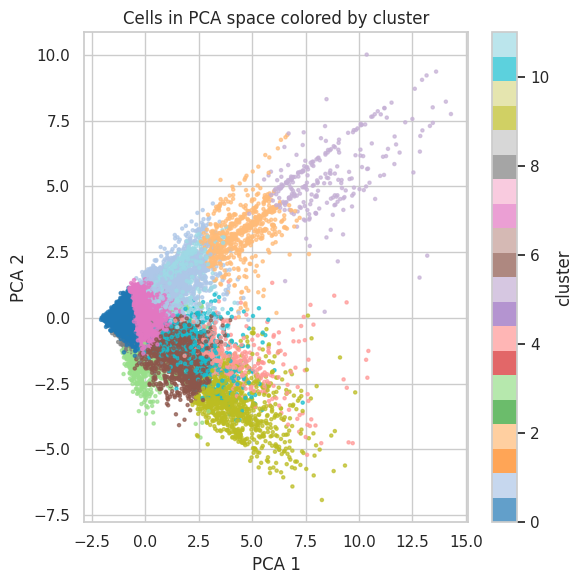

In [17]:
# 如细胞数过多，可先抽样一部分以便绘图
# if len(df) > 10000:
#     sampled = df.sample(n=10000, random_state=42)
# else:
#     sampled = df
sampled = df

plt.figure(figsize=(6, 6))
sc = plt.scatter(
    sampled['pca_1'],
    sampled['pca_2'],
    c=sampled['cluster'],
    s=5,
    cmap='tab20',
    alpha=0.7,
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Cells in PCA space colored by cluster')
plt.colorbar(sc, label='cluster')
plt.tight_layout()
plt.show()


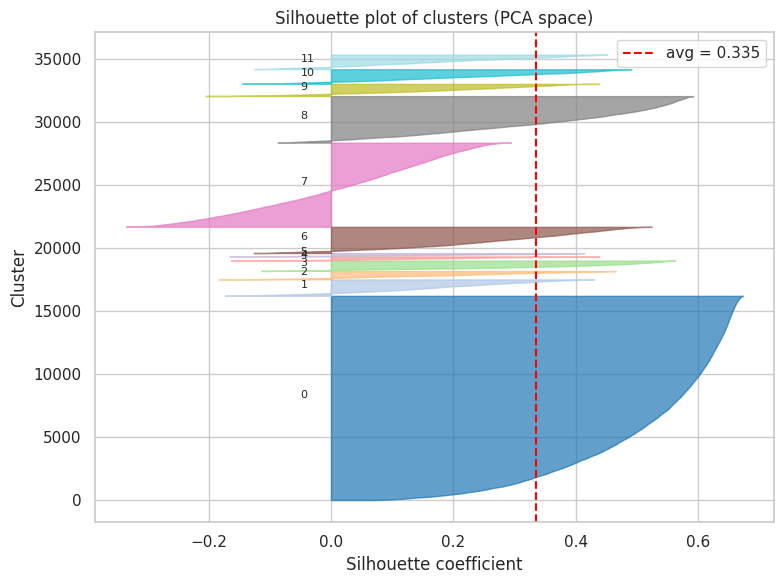

In [18]:
X = df[["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6"]].values
labels = df["cluster"].astype(int).values

silhouette_avg = silhouette_score(X, labels)
sample_silhouette_values = silhouette_samples(X, labels)

n_clusters = len(np.unique(labels))

plt.figure(figsize=(8, 6))
y_lower = 10
for i, c in enumerate(sorted(np.unique(labels))):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == c]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.tab20(float(i) / max(1, n_clusters - 1))
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(c), fontsize=8)

    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"avg = {silhouette_avg:.3f}")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette plot of clusters (PCA space)")
plt.legend()
plt.tight_layout()
plt.show()

## 2. 每个聚类的细胞数量分布


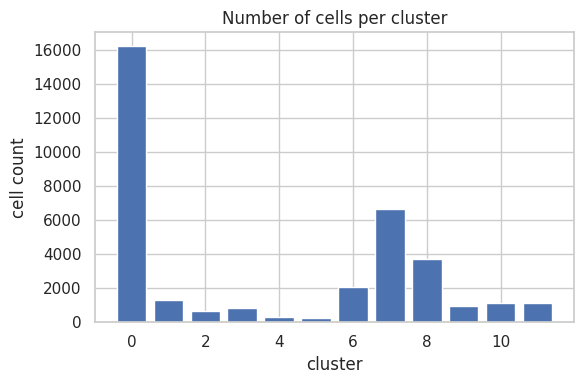

In [19]:
cluster_counts = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('cluster')
plt.ylabel('cell count')
plt.title('Number of cells per cluster')
plt.tight_layout()
plt.show()


## 3. 各簇平均 marker 表达热图

帮助快速查看每个聚类在不同 marker 上的平均表达，用于推断细胞类型。


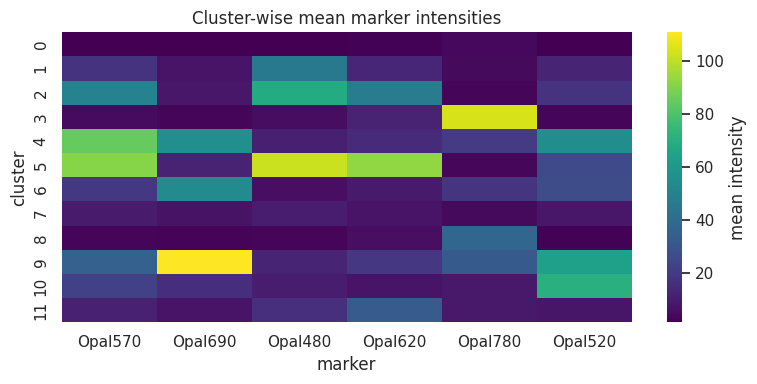

In [20]:
marker_cols = ['Opal570', 'Opal690', 'Opal480', 'Opal620', 'Opal780', 'Opal520']

cluster_means = (
    df.groupby('cluster')[marker_cols]
      .mean()
      .sort_index()
)

plt.figure(figsize=(8, 4))
sns.heatmap(
    cluster_means,
    cmap='viridis',
    annot=False,
    cbar_kws={'label': 'mean intensity'},
)
plt.title('Cluster-wise mean marker intensities')
plt.xlabel('marker')
plt.ylabel('cluster')
plt.tight_layout()
plt.show()


## 4. 单个 marker 在不同聚类中的分布（箱线图/小提琴图）

可根据需要修改 `marker` 变量。


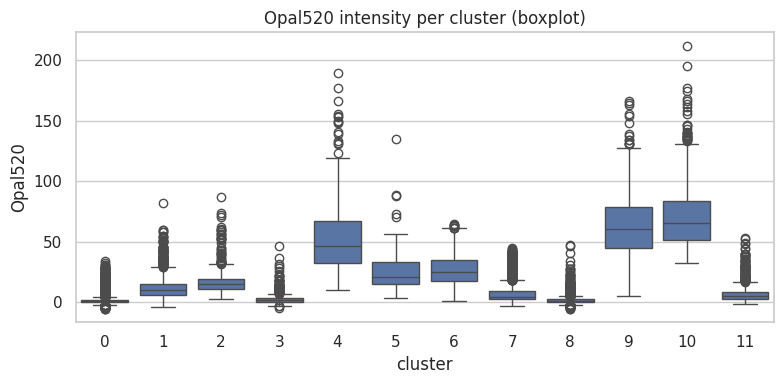

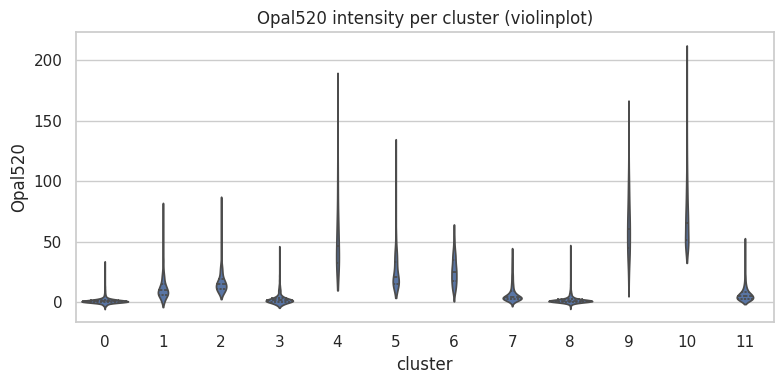

In [21]:
marker = 'Opal520'  # TODO: 根据面板选择你关注的 marker 名称

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='cluster', y=marker)
plt.title(f'{marker} intensity per cluster (boxplot)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x='cluster', y=marker, inner='quart', cut=0)
plt.title(f'{marker} intensity per cluster (violinplot)')
plt.tight_layout()
plt.show()


## 5. 按样本查看 cluster 组成（可选）

这里通过 `__source_csv` 推断 sample 名称，然后绘制 sample × cluster 的细胞比例热图。


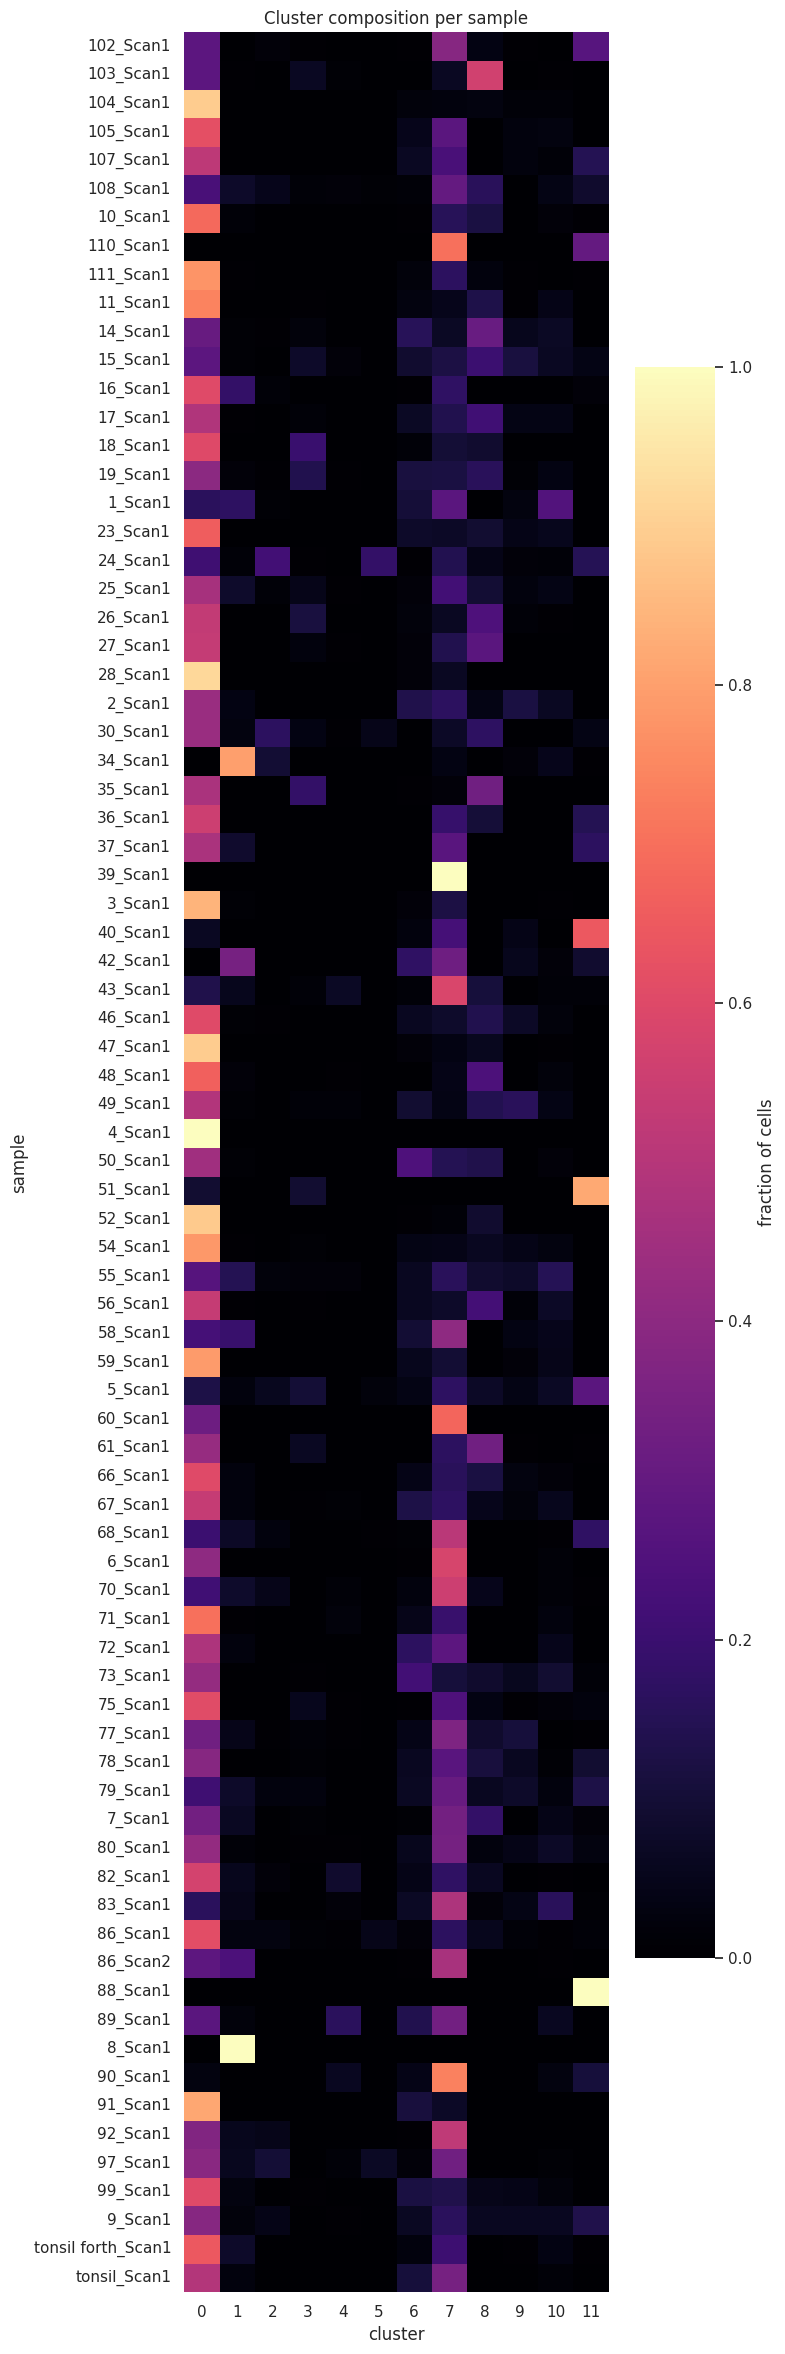

In [22]:
# 根据路径简单推断 sample 名称：
# 假设路径类似 .../outputs/<sample>/tile_x_y/features/features_matrix_mean.csv
def extract_sample(path: str) -> str:
    parts = path.split(os.sep)
    # 尝试找到 'outputs'，并取其后一个目录名作为 sample
    if 'outputs' in parts:
        idx = parts.index('outputs')
        if idx + 1 < len(parts):
            return parts[idx + 1]
    # 回退：使用上一级目录名
    return os.path.basename(os.path.dirname(os.path.dirname(path)))

df['sample'] = df['__source_csv'].apply(extract_sample)

ct = pd.crosstab(df['sample'], df['cluster'])
ct_norm = ct.div(ct.sum(axis=1), axis=0)  # 转成行内比例

plt.figure(figsize=(max(8, len(ct_norm.columns) * 0.6), max(6, len(ct_norm.index) * 0.3)))
sns.heatmap(
    ct_norm,
    cmap='magma',
    cbar_kws={'label': 'fraction of cells'},
)
plt.title('Cluster composition per sample')
plt.xlabel('cluster')
plt.ylabel('sample')
plt.tight_layout()
plt.show()
